In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.inspection import permutation_importance
import statsmodels.api as sm


In [3]:
# Step 1: Setup and Data Import

# Import necessary libraries
import pandas as pd

# Load the metrics summary CSV file
# Replace this with the actual path if you're running locally
file_path = "summary/metrics_summary.csv"  # Update this if needed
df = pd.read_csv(file_path)

# Display basic information about the dataset
print("DataFrame Info:")
print(df.info())

# Preview the first few rows
print("\nFirst 5 Rows:")
print(df.head())


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1821 entries, 0 to 1820
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   run_type              1821 non-null   object 
 1   input_file            1821 non-null   object 
 2   input_size            1821 non-null   int64  
 3   CLI_Flags             1821 non-null   object 
 4   hashing_method        1821 non-null   object 
 5   mod_value             1346 non-null   float64
 6   bucket_size           1821 non-null   int64  
 7   strategy              1821 non-null   object 
 8   c1                    1463 non-null   float64
 9   c2                    1463 non-null   float64
 10  collisions            1411 non-null   float64
 11  primary_collisions    1316 non-null   float64
 12  secondary_collisions  1316 non-null   float64
 13  comparisons           1805 non-null   float64
 14  insertions            1805 non-null   float64
 15  load_

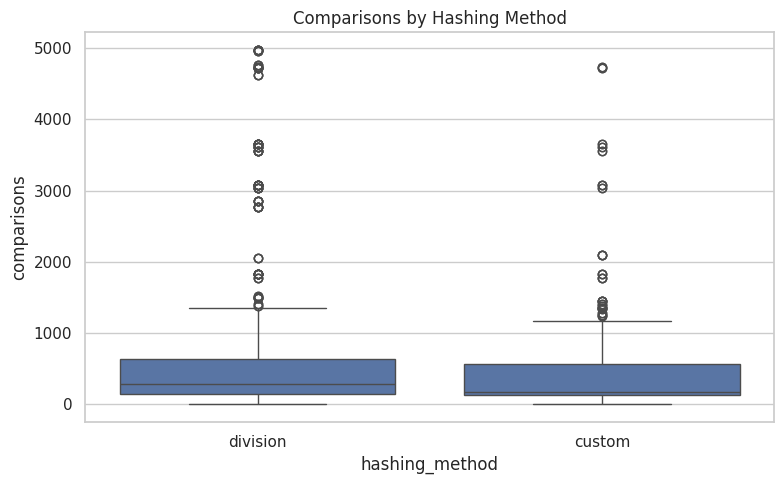

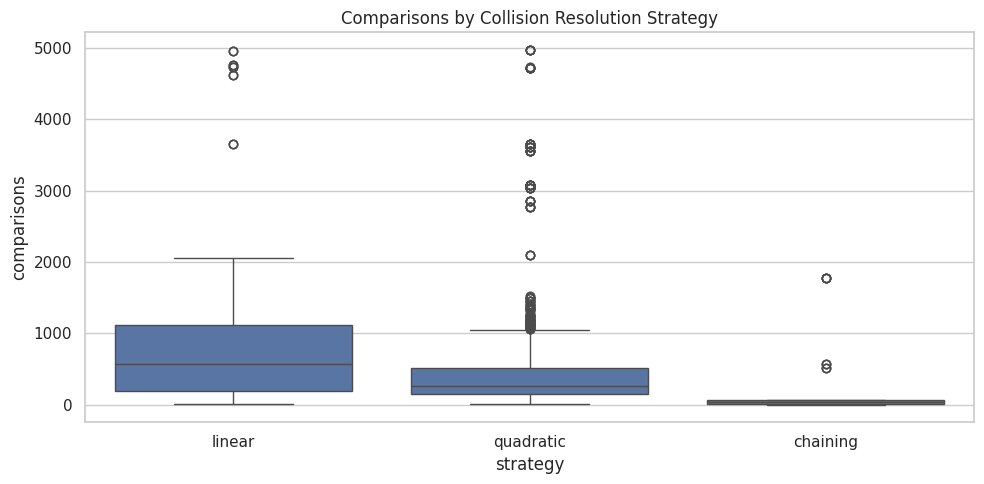

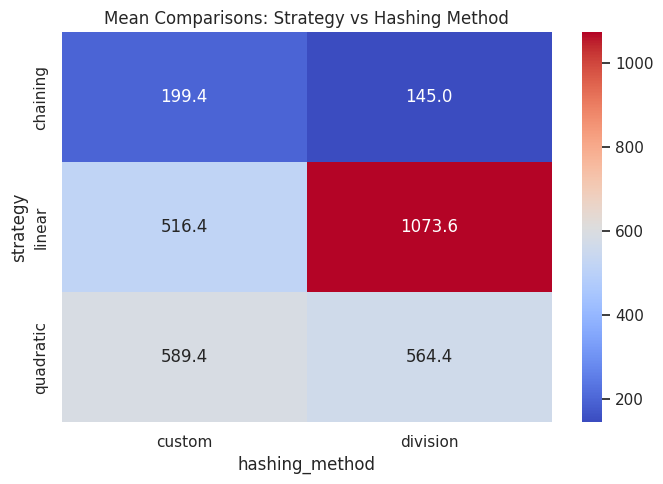

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style
sns.set(style="whitegrid")

# Optional: filter out rows with missing critical metrics
df_clean = df.dropna(subset=["comparisons", "collisions", "load_factor", "execution_time_sec"])

# ---------------------------
# Boxplot: Comparisons by Hashing Method
# ---------------------------
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_clean, x="hashing_method", y="comparisons")
plt.title("Comparisons by Hashing Method")
plt.tight_layout()
plt.show()

# ---------------------------
# Boxplot: Comparisons by Strategy
# ---------------------------
plt.figure(figsize=(10, 5))
sns.boxplot(data=df_clean, x="strategy", y="comparisons")
plt.title("Comparisons by Collision Resolution Strategy")
plt.tight_layout()
plt.show()

# ---------------------------
# Heatmap: Strategy vs Hashing Method (mean comparisons)
# ---------------------------
pivot = df_clean.pivot_table(
    index="strategy", 
    columns="hashing_method", 
    values="comparisons", 
    aggfunc="mean"
)

plt.figure(figsize=(7, 5))
sns.heatmap(pivot, annot=True, fmt=".1f", cmap="coolwarm")
plt.title("Mean Comparisons: Strategy vs Hashing Method")
plt.tight_layout()
plt.show()


/tmp/ipykernel_1684732/2535585216.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_valid["comparisons_per_insert"] = df_valid["comparisons"] / df_valid["insertions"]


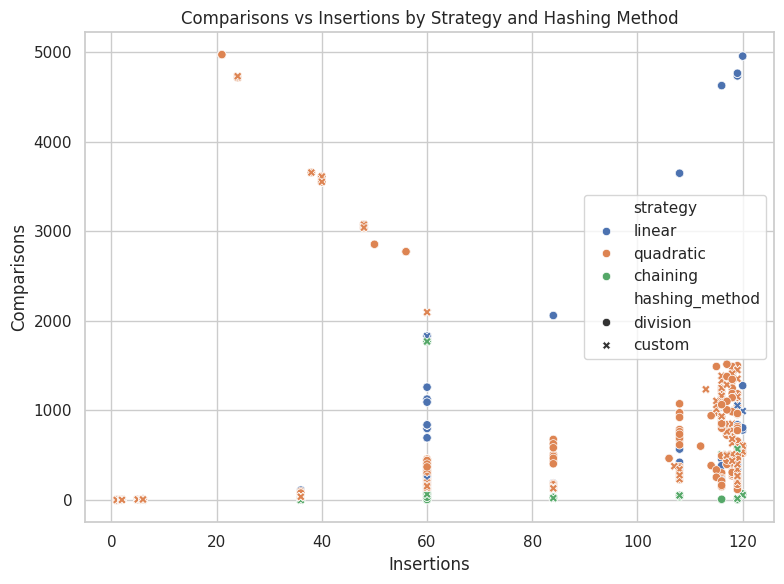

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter for rows with valid comparison and insertion data
df_valid = df.dropna(subset=["comparisons", "insertions"])

# Calculate comparisons per insertion as a new column
df_valid["comparisons_per_insert"] = df_valid["comparisons"] / df_valid["insertions"]

# Scatterplot to visualize the relationship
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_valid, x="insertions", y="comparisons", hue="strategy", style="hashing_method")
plt.title("Comparisons vs Insertions by Strategy and Hashing Method")
plt.xlabel("Insertions")
plt.ylabel("Comparisons")
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd

# Load the original CSV
df = pd.read_csv("summary/metrics_summary.csv")

# Define sets for categorization
edge_inputs = {
    "input_repeated_keys.txt",
    "input_near_capacity.txt",
    "input_boundary_keys.txt",
    "input_gaps.txt",
    "input_highload_collisions.txt",
}

invalid_inputs = {
    "input_non_integer.txt",
    "input_corrupt.txt",
    "input_missing_commas.txt",
    "input_overflow.txt",
}

stress_inputs = {
    "input_probe_stress.txt",
}

forced_collision_inputs = {
    "division_collisions_scheme1.txt",
    "division_collisions_scheme2.txt",
    "division_collisions_scheme3.txt",
    "custom_collisions_scheme12.txt",
    "custom_collisions_scheme13.txt",
    "custom_collisions_scheme14.txt"
}

# Function to classify input file type
def classify_input_type(filename: str) -> str:
    if filename in forced_collision_inputs:
        return "forced_collision"
    elif filename in edge_inputs:
        return "edge_case"
    elif filename in invalid_inputs:
        return "invalid"
    elif filename in stress_inputs:
        return "stress"
    else:
        return "normal"

# Apply classification
df["input_type"] = df["input_file"].apply(classify_input_type)

# Overwrite the original CSV
df.to_csv("summary/metrics_summary.csv", index=False)
print("✔ 'input_type' column updated and original file overwritten: metrics_summary.csv")


✔ 'input_type' column updated and original file overwritten: metrics_summary.csv


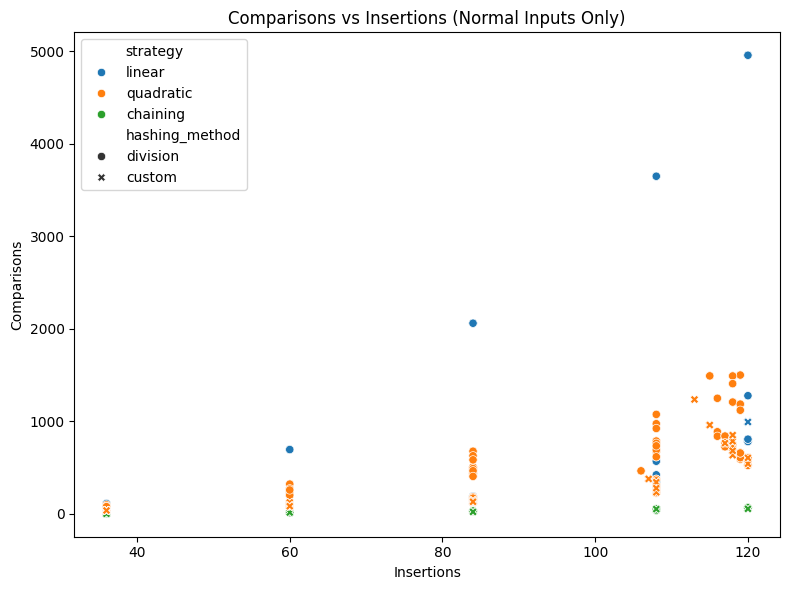

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter only normal-case input rows
df_normal = df[df["input_type"] == "normal"].copy()

# Compute comparisons per insert
df_normal["comparisons_per_insert"] = df_normal["comparisons"] / df_normal["insertions"]

# Plot comparisons vs insertions
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df_normal,
    x="insertions",
    y="comparisons",
    hue="strategy",
    style="hashing_method"
)
plt.title("Comparisons vs Insertions (Normal Inputs Only)")
plt.xlabel("Insertions")
plt.ylabel("Comparisons")
plt.tight_layout()
plt.show()


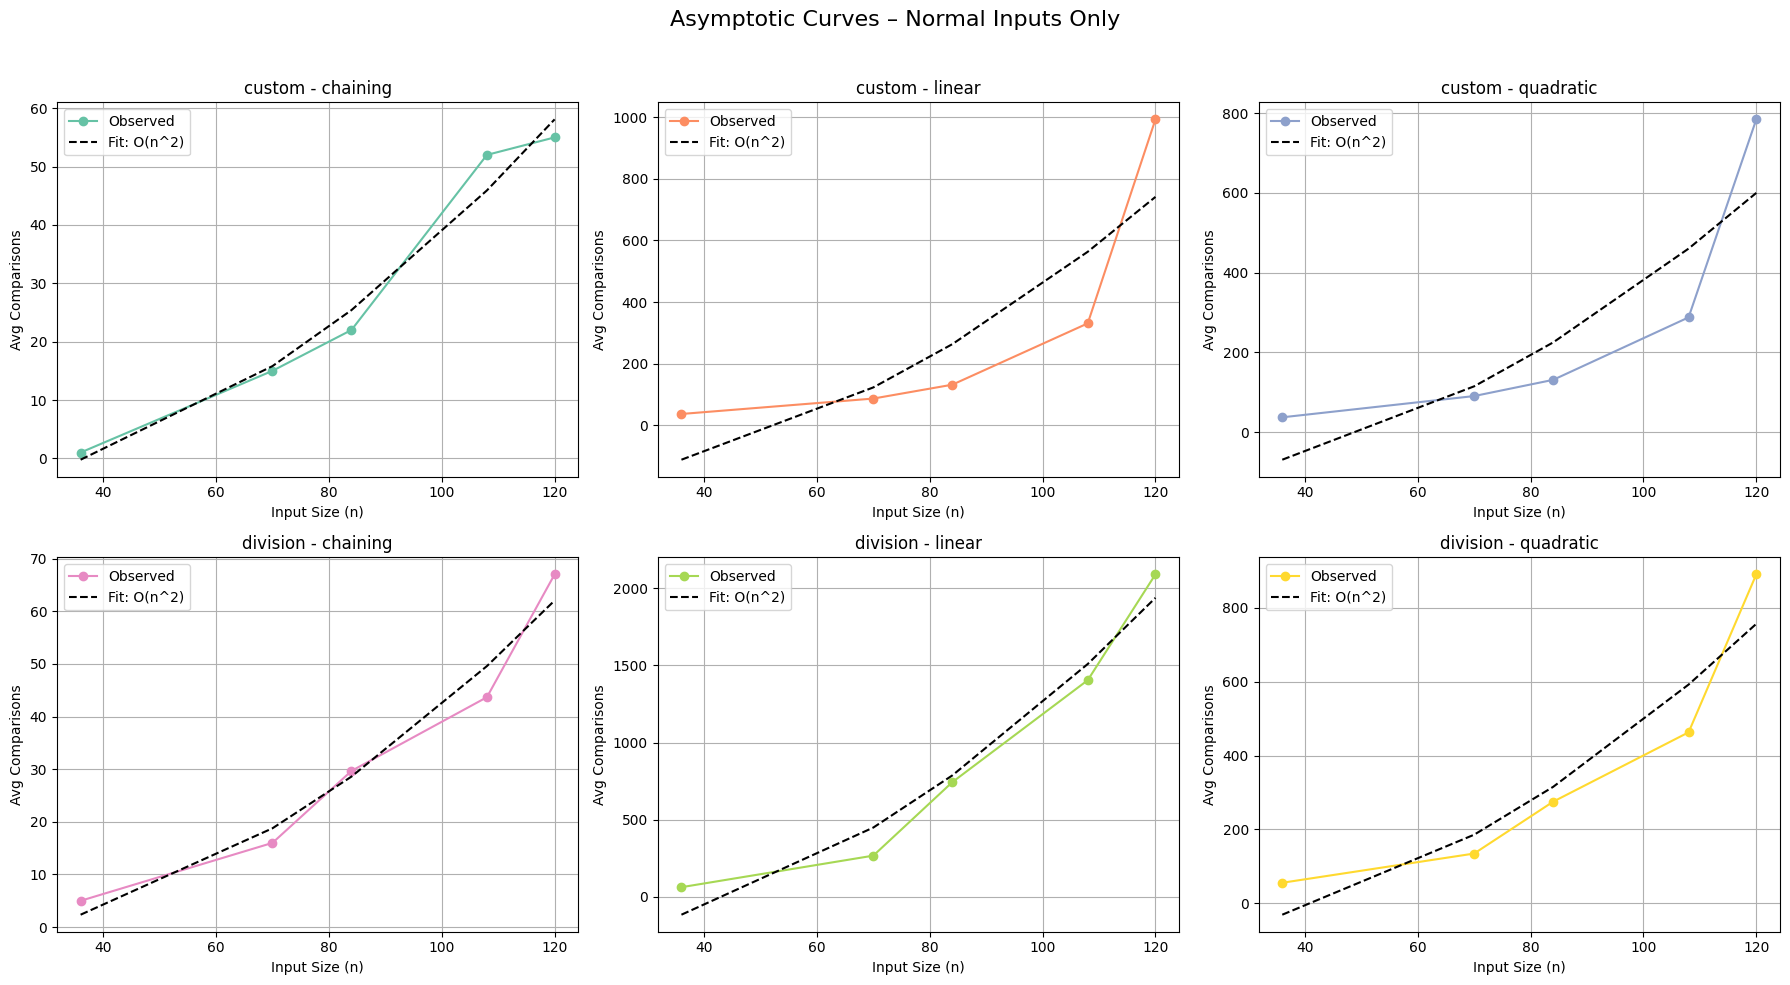

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit

# Load CSV
df = pd.read_csv("summary/metrics_summary.csv")

# Filter only 'normal' input types
df_normal = df[df["input_type"] == "normal"].copy()

# Define fitting functions
def constant(n, a): return a
def logn(n, a, b): return a * np.log(n) + b
def linear(n, a, b): return a * n + b
def nlogn(n, a, b): return a * n * np.log(n) + b
def quadratic(n, a, b): return a * n**2 + b
fits = {
    "O(1)": constant,
    "O(log n)": logn,
    "O(n)": linear,
    "O(n log n)": nlogn,
    "O(n^2)": quadratic
}

# Prepare aggregated data
agg_normal = (
    df_normal.groupby(["hashing_method", "strategy", "input_size"])
    .agg(avg_comparisons=("comparisons", "mean"))
    .reset_index()
)

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
palette = sns.color_palette("Set2", len(agg_normal["strategy"].unique()) * 2)

for idx, ((method, strategy), group) in enumerate(agg_normal.groupby(["hashing_method", "strategy"])):
    x = group["input_size"].values
    y = group["avg_comparisons"].values

    # Curve fitting
    best_fit = None
    min_error = float("inf")
    for label, func in fits.items():
        try:
            popt, _ = curve_fit(func, x, y, maxfev=5000)
            y_pred = func(x, *popt)
            mse = np.mean((y - y_pred)**2)
            if mse < min_error:
                min_error = mse
                best_fit = (label, func, popt, y_pred)
        except RuntimeError:
            continue

    ax = axes[idx]
    ax.plot(x, y, 'o-', label="Observed", color=palette[idx])
    if best_fit:
        label, func, popt, y_pred = best_fit
        ax.plot(x, y_pred, '--', label=f"Fit: {label}", color="black")
        ax.set_title(f"{method} - {strategy}")
    ax.set_xlabel("Input Size (n)")
    ax.set_ylabel("Avg Comparisons")
    ax.legend()
    ax.grid(True)

plt.suptitle("Asymptotic Curves – Normal Inputs Only", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


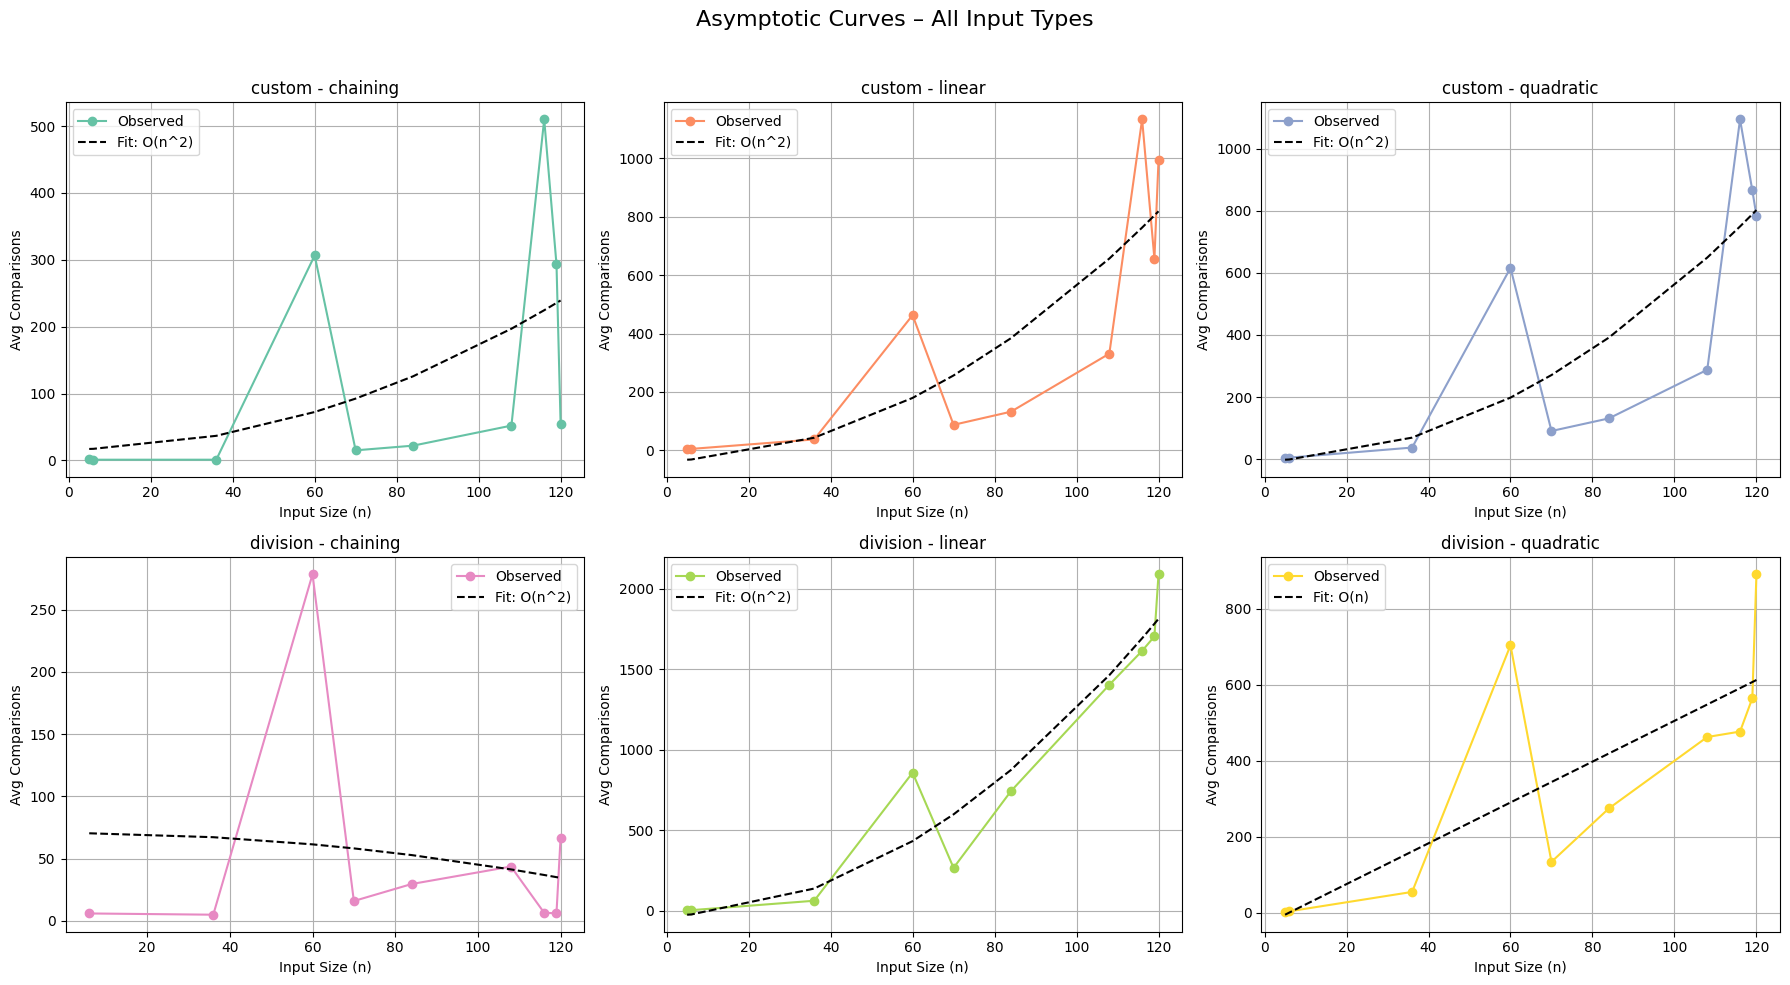

In [6]:
# Repeat with all inputs (no filtering)
df_all = pd.read_csv("summary/metrics_summary.csv")
df_all_clean = df_all.dropna(subset=["comparisons", "input_size", "strategy", "hashing_method"])

agg_all = (
    df_all_clean.groupby(["hashing_method", "strategy", "input_size"])
    .agg(avg_comparisons=("comparisons", "mean"))
    .reset_index()
)

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
palette = sns.color_palette("Set2", len(agg_all["strategy"].unique()) * 2)

for idx, ((method, strategy), group) in enumerate(agg_all.groupby(["hashing_method", "strategy"])):
    x = group["input_size"].values
    y = group["avg_comparisons"].values

    best_fit = None
    min_error = float("inf")
    for label, func in fits.items():
        try:
            popt, _ = curve_fit(func, x, y, maxfev=5000)
            y_pred = func(x, *popt)
            mse = np.mean((y - y_pred)**2)
            if mse < min_error:
                min_error = mse
                best_fit = (label, func, popt, y_pred)
        except RuntimeError:
            continue

    ax = axes[idx]
    ax.plot(x, y, 'o-', label="Observed", color=palette[idx])
    if best_fit:
        label, func, popt, y_pred = best_fit
        ax.plot(x, y_pred, '--', label=f"Fit: {label}", color="black")
        ax.set_title(f"{method} - {strategy}")
    ax.set_xlabel("Input Size (n)")
    ax.set_ylabel("Avg Comparisons")
    ax.legend()
    ax.grid(True)

plt.suptitle("Asymptotic Curves – All Input Types", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
import os
import subprocess
import pandas as pd

INPUT_DIR = "input"
OUTPUT_DIR = "output"
SUMMARY_FILE = "summary/canonical_metrics.csv"

CANONICAL_INPUTS = [
    "LabHashingInput.txt", "input_36.txt", "input_84.txt",
    "input_108.txt", "input_120.txt"
]

SCHEMES = list(range(1, 15))

scheme_flags = {
    1:  "--hashing division --mod 120 --bucket 1 --strategy linear",
    2:  "--hashing division --mod 120 --bucket 1 --strategy quadratic --c1 0.5 --c2 0.5",
    3:  "--hashing division --mod 120 --bucket 1 --strategy chaining",
    4:  "--hashing division --mod 127 --bucket 1 --strategy linear",
    5:  "--hashing division --mod 127 --bucket 1 --strategy quadratic --c1 0.5 --c2 0.5",
    6:  "--hashing division --mod 127 --bucket 1 --strategy chaining",
    7:  "--hashing division --mod 113 --bucket 1 --strategy linear",
    8:  "--hashing division --mod 113 --bucket 1 --strategy quadratic --c1 0.5 --c2 0.5",
    9:  "--hashing division --mod 113 --bucket 1 --strategy chaining",
    10: "--hashing division --mod 41 --bucket 3 --strategy linear",
    11: "--hashing division --mod 41 --bucket 3 --strategy quadratic --c1 0.5 --c2 0.5",
    12: "--hashing custom --bucket 1 --strategy linear",
    13: "--hashing custom --bucket 1 --strategy quadratic --c1 0.5 --c2 0.5",
    14: "--hashing custom --bucket 1 --strategy chaining",
}

header = [
    "run_type", "input_file", "input_size", "CLI_Flags", "hashing_method",
    "mod_value", "bucket_size", "strategy", "c1", "c2", "collisions",
    "primary_collisions", "secondary_collisions", "comparisons",
    "insertions", "load_factor", "execution_time_sec", "memory_usage_bytes"
]
rows = []

os.makedirs("summary", exist_ok=True)
os.makedirs("output", exist_ok=True)

def extract_metrics(run_type, input_file, output_file, flags):
    input_path = os.path.join(INPUT_DIR, input_file)
    input_size = sum(1 for _ in open(input_path)) if os.path.exists(input_path) else "NA"

    metrics = dict.fromkeys([
        "collisions", "primary_collisions", "secondary_collisions",
        "comparisons", "insertions", "load_factor",
        "execution_time_sec", "memory_usage_bytes"
    ], "NA")

    if os.path.exists(output_file):
        with open(output_file) as f:
            for line in f:
                line = line.strip()

                if "# of primary collisions:" in line:
                    try:
                        # Match: "# of primary collisions: 19, secondary collisions: 11, total collisions: 30"
                        m = re.search(r"# of primary collisions:\s*(\d+),\s*secondary collisions:\s*(\d+),\s*total collisions:\s*(\d+)", line)
                        if m:
                            metrics["primary_collisions"] = m.group(1)
                            metrics["secondary_collisions"] = m.group(2)
                            metrics["collisions"] = m.group(3)
                    except Exception:
                        pass

                elif "# of collisions:" in line:
                    try:
                        # Match: "# of collisions: 17" (e.g., chaining)
                        m = re.search(r"# of collisions:\s*(\d+)", line)
                        if m:
                            metrics["collisions"] = m.group(1)
                    except Exception:
                        pass

                elif "# of comparisons:" in line:
                    try:
                        # Match: "# of comparisons: 85, records inserted: 60, load factor: 0.5"
                        m = re.search(r"# of comparisons:\s*(\d+),\s*records inserted:\s*(\d+),\s*load factor:\s*([\d.]+)", line)
                        if m:
                            metrics["comparisons"] = m.group(1)
                            metrics["insertions"] = m.group(2)
                            metrics["load_factor"] = m.group(3)
                    except Exception:
                        pass

                elif "Execution Time:" in line:
                    metrics["execution_time_sec"] = line.split(":")[1].replace("seconds", "").strip()
                elif "Memory Usage:" in line:
                    metrics["memory_usage_bytes"] = line.split(":")[1].replace("bytes", "").strip()

    def get_flag(flag):
        return flags.split(flag)[1].split()[0] if flag in flags else ""

    return [
        run_type, input_file, input_size, flags,
        get_flag("--hashing"), get_flag("--mod"), get_flag("--bucket"), get_flag("--strategy"),
        get_flag("--c1"), get_flag("--c2"),
        metrics["collisions"], metrics["primary_collisions"], metrics["secondary_collisions"],
        metrics["comparisons"], metrics["insertions"], metrics["load_factor"],
        metrics["execution_time_sec"], metrics["memory_usage_bytes"]
    ]


    def get_flag(flag):
        return flags.split(flag)[1].split()[0] if flag in flags else ""

    return [
        run_type, input_file, input_size, flags,
        get_flag("--hashing"), get_flag("--mod"), get_flag("--bucket"), get_flag("--strategy"),
        get_flag("--c1"), get_flag("--c2"),
        metrics["collisions"], metrics["primary_collisions"], metrics["secondary_collisions"],
        metrics["comparisons"], metrics["insertions"], metrics["load_factor"],
        metrics["execution_time_sec"], metrics["memory_usage_bytes"]
    ]

# Run all canonical inputs and schemes
for input_file in CANONICAL_INPUTS:
    for scheme in SCHEMES:
        flags = scheme_flags[scheme]
        run_type = f"scheme_{scheme}"
        output_path = os.path.join(OUTPUT_DIR, f"{run_type}_{input_file.replace('.txt', '')}.txt")

        cmd = f'mvn compile exec:java -Dexec.mainClass="edu.jhu.algos.Main" ' \
              f'-Dexec.args="{flags} --input {INPUT_DIR}/{input_file} --output {output_path}"'

        print(f"▶ Running {run_type} on {input_file}")
        subprocess.run(cmd, shell=True)

        rows.append(extract_metrics(run_type, input_file, output_path, flags))

# Save to CSV
df = pd.DataFrame(rows, columns=header)
df.to_csv(SUMMARY_FILE, index=False)
print(f"✅ Canonical metrics written to {SUMMARY_FILE}")


▶ Running scheme_1 on LabHashingInput.txt
[INFO] Scanning for projects...
[INFO] 
[INFO] ---------------------< edu.jhu.algos:kmerHashing >----------------------
[INFO] Building kmerHashing 1.0-SNAPSHOT
[INFO]   from pom.xml
[INFO] --------------------------------[ jar ]---------------------------------
[INFO] 
[INFO] --- resources:3.3.1:resources (default-resources) @ kmerHashing ---
[WARNING] Using platform encoding (UTF-8 actually) to copy filtered resources, i.e. build is platform dependent!
[INFO] skip non existing resourceDirectory /home/secondbook5/JHU_Bioinformatics/AlgorithmsBioinformatics/kmerHashing/src/main/resources
[INFO] 
[INFO] --- compiler:3.8.1:compile (default-compile) @ kmerHashing ---
[INFO] Nothing to compile - all classes are up to date
[INFO] 
[INFO] --- exec:3.5.0:java (default-cli) @ kmerHashing ---
Reading file: input/LabHashingInput.txt
Read key: 12501
Read key: 84763
Read key: 22599
Read key: 2698
Read key: 55555
Read key: 72501
Read key: 99999
Read key: 33

 Chart saved to: plots/scheme_1_LabHashingInput_manual_division_mod120_bucket1_linear.png
[INFO] ------------------------------------------------------------------------
[INFO] BUILD SUCCESS
[INFO] ------------------------------------------------------------------------
[INFO] Total time:  3.440 s
[INFO] Finished at: 2025-04-02T15:59:04-04:00
[INFO] ------------------------------------------------------------------------
▶ Running scheme_2 on LabHashingInput.txt
[INFO] Scanning for projects...
[INFO] 
[INFO] ---------------------< edu.jhu.algos:kmerHashing >----------------------
[INFO] Building kmerHashing 1.0-SNAPSHOT
[INFO]   from pom.xml
[INFO] --------------------------------[ jar ]---------------------------------
[INFO] 
[INFO] --- resources:3.3.1:resources (default-resources) @ kmerHashing ---
[WARNING] Using platform encoding (UTF-8 actually) to copy filtered resources, i.e. build is platform dependent!
[INFO] skip non existing resourceDirectory /home/secondbook5/JHU_Bioinform

 None    
None    None    26987   None    None    
None    81111   None    47993   None    
55555   67676   None    358     37319   

Execution Time: 6.131e-04 seconds
Memory Usage: 0.000e+00 bytes
 Chart saved to: plots/scheme_2_LabHashingInput_manual_division_mod120_bucket1_quadratic.png
[INFO] ------------------------------------------------------------------------
[INFO] BUILD SUCCESS
[INFO] ------------------------------------------------------------------------
[INFO] Total time:  2.969 s
[INFO] Finished at: 2025-04-02T15:59:10-04:00
[INFO] ------------------------------------------------------------------------
▶ Running scheme_3 on LabHashingInput.txt
[INFO] Scanning for projects...
[INFO] 
[INFO] ---------------------< edu.jhu.algos:kmerHashing >----------------------
[INFO] Building kmerHashing 1.0-SNAPSHOT
[INFO]   from pom.xml
[INFO] --------------------------------[ jar ]---------------------------------
[INFO] 
[INFO] --- resources:3.3.1:resources (default-resources) @ km

 Chart saved to: plots/scheme_3_LabHashingInput_manual_division_mod120_bucket1_chaining.png
[INFO] ------------------------------------------------------------------------
[INFO] BUILD SUCCESS
[INFO] ------------------------------------------------------------------------
[INFO] Total time:  3.805 s
[INFO] Finished at: 2025-04-02T15:59:17-04:00
[INFO] ------------------------------------------------------------------------
▶ Running scheme_4 on LabHashingInput.txt
[INFO] Scanning for projects...
[INFO] 
[INFO] ---------------------< edu.jhu.algos:kmerHashing >----------------------
[INFO] Building kmerHashing 1.0-SNAPSHOT
[INFO]   from pom.xml
[INFO] --------------------------------[ jar ]---------------------------------
[INFO] 
[INFO] --- resources:3.3.1:resources (default-resources) @ kmerHashing ---
[WARNING] Using platform encoding (UTF-8 actually) to copy filtered resources, i.e. build is platform dependent!
[INFO] skip non existing resourceDirectory /home/secondbook5/JHU_Bioinfo

 Chart saved to: plots/scheme_4_LabHashingInput_manual_division_mod127_bucket1_linear.png
[INFO] ------------------------------------------------------------------------
[INFO] BUILD SUCCESS
[INFO] ------------------------------------------------------------------------
[INFO] Total time:  4.735 s
[INFO] Finished at: 2025-04-02T15:59:25-04:00
[INFO] ------------------------------------------------------------------------
▶ Running scheme_5 on LabHashingInput.txt
[INFO] Scanning for projects...
[INFO] 
[INFO] ---------------------< edu.jhu.algos:kmerHashing >----------------------
[INFO] Building kmerHashing 1.0-SNAPSHOT
[INFO]   from pom.xml
[INFO] --------------------------------[ jar ]---------------------------------
[INFO] 
[INFO] --- resources:3.3.1:resources (default-resources) @ kmerHashing ---
[WARNING] Using platform encoding (UTF-8 actually) to copy filtered resources, i.e. build is platform dependent!
[INFO] skip non existing resourceDirectory /home/secondbook5/JHU_Bioinform

  
None    2698    2699    None    78901   
39531   None    14763   None    None    
99989   None    None    None    78911   
92501   None    None    None    None    
99999   56565   None    38531   84763   
12501   55555   12503   None    None    
None    None    54545   26987   None    
None    33975   None    None    None    
19501   None    67890   None    None    
89102   None    None    None    None    
90123   None    None    42501   None    
81111   None    None    62699   71717   
None    1234    54321   22699   None    
59531   18765   None    None    22705   
None    None    None    None    358     
None    90911   None    37319   None    
None    72501   67676   13956   57391   
47993   None    None    None    None    

Execution Time: 2.769e-04 seconds
Memory Usage: 0.000e+00 bytes
 Chart saved to: plots/scheme_5_LabHashingInput_manual_division_mod127_bucket1_quadratic.png
[INFO] ------------------------------------------------------------------------
[INFO] BUILD SUCCESS


None                90911 -> None       None                37319 -> None       None                
None                72501 -> None       67676 -> None       13956 -> None       47993 -> 57391 -> None
None                None                None                None                None                

Execution Time: 3.758e-04 seconds
Memory Usage: 0.000e+00 bytes
 Chart saved to: plots/scheme_6_LabHashingInput_manual_division_mod127_bucket1_chaining.png
[INFO] ------------------------------------------------------------------------
[INFO] BUILD SUCCESS
[INFO] ------------------------------------------------------------------------
[INFO] Total time:  2.986 s
[INFO] Finished at: 2025-04-02T15:59:37-04:00
[INFO] ------------------------------------------------------------------------
▶ Running scheme_7 on LabHashingInput.txt
[INFO] Scanning for projects...
[INFO] 
[INFO] ---------------------< edu.jhu.algos:kmerHashing >----------------------
[INFO] Building kmerHashing 1.0-SNAPSHOT


 Chart saved to: plots/scheme_7_LabHashingInput_manual_division_mod113_bucket1_linear.png
[INFO] ------------------------------------------------------------------------
[INFO] BUILD SUCCESS
[INFO] ------------------------------------------------------------------------
[INFO] Total time:  3.682 s
[INFO] Finished at: 2025-04-02T15:59:44-04:00
[INFO] ------------------------------------------------------------------------
▶ Running scheme_8 on LabHashingInput.txt
[INFO] Scanning for projects...
[INFO] 
[INFO] ---------------------< edu.jhu.algos:kmerHashing >----------------------
[INFO] Building kmerHashing 1.0-SNAPSHOT
[INFO]   from pom.xml
[INFO] --------------------------------[ jar ]---------------------------------
[INFO] 
[INFO] --- resources:3.3.1:resources (default-resources) @ kmerHashing ---
[WARNING] Using platform encoding (UTF-8 actually) to copy filtered resources, i.e. build is platform dependent!
[INFO] skip non existing resourceDirectory /home/secondbook5/JHU_Bioinform

 Chart saved to: plots/scheme_8_LabHashingInput_manual_division_mod113_bucket1_quadratic.png
[INFO] ------------------------------------------------------------------------
[INFO] BUILD SUCCESS
[INFO] ------------------------------------------------------------------------
[INFO] Total time:  3.028 s
[INFO] Finished at: 2025-04-02T15:59:50-04:00
[INFO] ------------------------------------------------------------------------
▶ Running scheme_9 on LabHashingInput.txt
[INFO] Scanning for projects...
[INFO] 
[INFO] ---------------------< edu.jhu.algos:kmerHashing >----------------------
[INFO] Building kmerHashing 1.0-SNAPSHOT
[INFO]   from pom.xml
[INFO] --------------------------------[ jar ]---------------------------------
[INFO] 
[INFO] --- resources:3.3.1:resources (default-resources) @ kmerHashing ---
[WARNING] Using platform encoding (UTF-8 actually) to copy filtered resources, i.e. build is platform dependent!
[INFO] skip non existing resourceDirectory /home/secondbook5/JHU_Bioinf

 Chart saved to: plots/scheme_9_LabHashingInput_manual_division_mod113_bucket1_chaining.png
[INFO] ------------------------------------------------------------------------
[INFO] BUILD SUCCESS
[INFO] ------------------------------------------------------------------------
[INFO] Total time:  2.942 s
[INFO] Finished at: 2025-04-02T15:59:55-04:00
[INFO] ------------------------------------------------------------------------
▶ Running scheme_10 on LabHashingInput.txt
[INFO] Scanning for projects...
[INFO] 
[INFO] ---------------------< edu.jhu.algos:kmerHashing >----------------------
[INFO] Building kmerHashing 1.0-SNAPSHOT
[INFO]   from pom.xml
[INFO] --------------------------------[ jar ]---------------------------------
[INFO] 
[INFO] --- resources:3.3.1:resources (default-resources) @ kmerHashing ---
[WARNING] Using platform encoding (UTF-8 actually) to copy filtered resources, i.e. build is platform dependent!
[INFO] skip non existing resourceDirectory /home/secondbook5/JHU_Bioinf

 Chart saved to: plots/scheme_10_LabHashingInput_manual_division_mod41_bucket3_linear.png
[INFO] ------------------------------------------------------------------------
[INFO] BUILD SUCCESS
[INFO] ------------------------------------------------------------------------
[INFO] Total time:  2.872 s
[INFO] Finished at: 2025-04-02T16:00:02-04:00
[INFO] ------------------------------------------------------------------------
▶ Running scheme_11 on LabHashingInput.txt
[INFO] Scanning for projects...
[INFO] 
[INFO] ---------------------< edu.jhu.algos:kmerHashing >----------------------
[INFO] Building kmerHashing 1.0-SNAPSHOT
[INFO]   from pom.xml
[INFO] --------------------------------[ jar ]---------------------------------
[INFO] 
[INFO] --- resources:3.3.1:resources (default-resources) @ kmerHashing ---
[WARNING] Using platform encoding (UTF-8 actually) to copy filtered resources, i.e. build is platform dependent!
[INFO] skip non existing resourceDirectory /home/secondbook5/JHU_Bioinfor

Read key: 12501
Read key: 84763
Read key: 22599
Read key: 2698
Read key: 55555
Read key: 72501
Read key: 99999
Read key: 33975
Read key: 62501
Read key: 42501
Read key: 90911
Read key: 42699
Read key: 80800
Read key: 18765
Read key: 78901
Read key: 2699
Read key: 31753
Read key: 22699
Read key: 67676
Read key: 59531
Read key: 13956
Read key: 1234
Read key: 90123
Read key: 78888
Read key: 39531
Read key: 49531
Read key: 56565
Read key: 89531
Read key: 67890
Read key: 22999
Read key: 81111
Read key: 79531
Read key: 37319
Read key: 27431
Read key: 92501
Read key: 9531
Read key: 47893
Read key: 14763
Read key: 62699
Read key: 57391
Read key: 54321
Read key: 35197
Read key: 71717
Read key: 89102
Read key: 49287
Read key: 26987
Read key: 11
Read key: 99989
Read key: 64763
Read key: 19501
Read key: 12503
Read key: 22705
Read key: 38531
Read key: 47993
Read key: 54545
Read key: 62000
Read key: 78911
Read key: 88531
Read key: 92345
Read key: 358

Finished reading file. Total keys loaded: 60
ori

 Chart saved to: plots/scheme_12_LabHashingInput_manual_custom_modnone_bucket1_linear.png
[INFO] ------------------------------------------------------------------------
[INFO] BUILD SUCCESS
[INFO] ------------------------------------------------------------------------
[INFO] Total time:  3.287 s
[INFO] Finished at: 2025-04-02T16:00:15-04:00
[INFO] ------------------------------------------------------------------------
▶ Running scheme_13 on LabHashingInput.txt
[INFO] Scanning for projects...
[INFO] 
[INFO] ---------------------< edu.jhu.algos:kmerHashing >----------------------
[INFO] Building kmerHashing 1.0-SNAPSHOT
[INFO]   from pom.xml
[INFO] --------------------------------[ jar ]---------------------------------
[INFO] 
[INFO] --- resources:3.3.1:resources (default-resources) @ kmerHashing ---
[WARNING] Using platform encoding (UTF-8 actually) to copy filtered resources, i.e. build is platform dependent!
[INFO] skip non existing resourceDirectory /home/secondbook5/JHU_Bioinfor

 Chart saved to: plots/scheme_13_LabHashingInput_manual_custom_modnone_bucket1_quadratic.png
[INFO] ------------------------------------------------------------------------
[INFO] BUILD SUCCESS
[INFO] ------------------------------------------------------------------------
[INFO] Total time:  3.937 s
[INFO] Finished at: 2025-04-02T16:00:23-04:00
[INFO] ------------------------------------------------------------------------
▶ Running scheme_14 on LabHashingInput.txt
[INFO] Scanning for projects...
[INFO] 
[INFO] ---------------------< edu.jhu.algos:kmerHashing >----------------------
[INFO] Building kmerHashing 1.0-SNAPSHOT
[INFO]   from pom.xml
[INFO] --------------------------------[ jar ]---------------------------------
[INFO] 
[INFO] --- resources:3.3.1:resources (default-resources) @ kmerHashing ---
[WARNING] Using platform encoding (UTF-8 actually) to copy filtered resources, i.e. build is platform dependent!
[INFO] skip non existing resourceDirectory /home/secondbook5/JHU_Bioin

None                
None                None                99999 -> None       None                54545 -> 47993 -> None
None                None                None                19501 -> None       None                
None                None                None                None                None                
78888 -> None       None                67890 -> 1234 -> None22599 -> None       67676 -> None       
None                None                2699 -> None        None                None                
None                None                None                92345 -> None       None                
55555 -> None       None                78901 -> 72501 -> NoneNone                None                
13956 -> None       None                89102 -> None       39531 -> None       None                
47893 -> None       None                None                None                None                
None                14763 -> 90123 -> 42699 -> None62000 -> None 

Error: Hash table is full. Could not insert key: 129696
Error: Hash table is full. Could not insert key: 250488


 Chart saved to: plots/scheme_5_input_120_manual_division_mod127_bucket1_quadratic.png
[INFO] ------------------------------------------------------------------------
[INFO] BUILD SUCCESS
[INFO] ------------------------------------------------------------------------
[INFO] Total time:  6.456 s
[INFO] Finished at: 2025-04-02T16:06:05-04:00
[INFO] ------------------------------------------------------------------------
▶ Running scheme_6 on input_120.txt
[INFO] Scanning for projects...
[INFO] 
[INFO] ---------------------< edu.jhu.algos:kmerHashing >----------------------
[INFO] Building kmerHashing 1.0-SNAPSHOT
[INFO]   from pom.xml
[INFO] --------------------------------[ jar ]---------------------------------
[INFO] 
[INFO] --- resources:3.3.1:resources (default-resources) @ kmerHashing ---
[WARNING] Using platform encoding (UTF-8 actually) to copy filtered resources, i.e. build is platform dependent!
[INFO] skip non existing resourceDirectory /home/secondbook5/JHU_Bioinformatics/Alg

Error: Hash table is full. Could not insert key: 450011


 Chart saved to: plots/scheme_8_input_120_manual_division_mod113_bucket1_quadratic.png
[INFO] ------------------------------------------------------------------------
[INFO] BUILD SUCCESS
[INFO] ------------------------------------------------------------------------
[INFO] Total time:  4.968 s
[INFO] Finished at: 2025-04-02T16:06:38-04:00
[INFO] ------------------------------------------------------------------------
▶ Running scheme_9 on input_120.txt
[INFO] Scanning for projects...
[INFO] 
[INFO] ---------------------< edu.jhu.algos:kmerHashing >----------------------
[INFO] Building kmerHashing 1.0-SNAPSHOT
[INFO]   from pom.xml
[INFO] --------------------------------[ jar ]---------------------------------
[INFO] 
[INFO] --- resources:3.3.1:resources (default-resources) @ kmerHashing ---
[WARNING] Using platform encoding (UTF-8 actually) to copy filtered resources, i.e. build is platform dependent!
[INFO] skip non existing resourceDirectory /home/secondbook5/JHU_Bioinformatics/Alg

Error: Hash table is full. Could not insert key: 648842


 Chart saved to: plots/scheme_11_input_120_manual_division_mod41_bucket3_quadratic.png
[INFO] ------------------------------------------------------------------------
[INFO] BUILD SUCCESS
[INFO] ------------------------------------------------------------------------
[INFO] Total time:  6.110 s
[INFO] Finished at: 2025-04-02T16:07:05-04:00
[INFO] ------------------------------------------------------------------------
▶ Running scheme_12 on input_120.txt
[INFO] Scanning for projects...
[INFO] 
[INFO] ---------------------< edu.jhu.algos:kmerHashing >----------------------
[INFO] Building kmerHashing 1.0-SNAPSHOT
[INFO]   from pom.xml
[INFO] --------------------------------[ jar ]---------------------------------
[INFO] 
[INFO] --- resources:3.3.1:resources (default-resources) @ kmerHashing ---
[WARNING] Using platform encoding (UTF-8 actually) to copy filtered resources, i.e. build is platform dependent!
[INFO] skip non existing resourceDirectory /home/secondbook5/JHU_Bioinformatics/Al

Error: Hash table is full. Could not insert key: 648842
Error: Hash table is full. Could not insert key: 328813


None    323659  771587  
763955  355963  849109  305569  286800  
611358  27806   27643   343674  266266  
466431  129696  756007  130118  776206  
691613  401518  75842   250159  710788  
299425  887134  497794  107440  695141  
660953  585036  None    116781  500694  
901067  470352  188037  515290  306410  
657509  473993  118510  122675  303857  
796405  721018  630399  865047  294193  
854137  173347  451064  860494  52629   
763593  590452  56417   351294  699891  

Execution Time: 1.641e-03 seconds
Memory Usage: 0.000e+00 bytes
 Chart saved to: plots/scheme_13_input_120_manual_custom_modnone_bucket1_quadratic.png
[INFO] ------------------------------------------------------------------------
[INFO] BUILD SUCCESS
[INFO] ------------------------------------------------------------------------
[INFO] Total time:  3.789 s
[INFO] Finished at: 2025-04-02T16:07:23-04:00
[INFO] ------------------------------------------------------------------------
▶ Running scheme_14 on input_120.txt


In [1]:
import os
import re
import pandas as pd

# Path to output folder and result file
OUTPUT_DIR = "output"
CSV_FILE = "summary/canonical_metrics.csv"

# Define pattern for parsing
config_pattern = re.compile(r"scheme (\d+) \((\w+)\) - modulo: ([\w/]+), bucket size: (\d+), (\w+)")
primary_stats = re.compile(r"# of primary collisions: (\d+), secondary collisions: (\d+), total collisions: (\d+)")
simple_collisions = re.compile(r"# of collisions: (\d+)")
comp_stats = re.compile(r"# of comparisons: (\d+), records inserted: (\d+), load factor: ([\d.]+)")
time_pattern = re.compile(r"Execution Time: ([\d.eE+-]+) seconds")
memory_pattern = re.compile(r"Memory Usage: ([\d.eE+-]+) bytes")

# Columns for canonical CSV
columns = [
    "filename", "scheme", "hashing_method", "mod_value", "bucket_size", "strategy",
    "collisions", "primary_collisions", "secondary_collisions",
    "comparisons", "insertions", "load_factor",
    "execution_time", "memory_usage"
]

# Collector for rows
rows = []

# Iterate over each file
for fname in sorted(os.listdir(OUTPUT_DIR)):
    if not fname.endswith(".txt"):
        continue

    row = {
        "filename": fname,
        "scheme": None, "hashing_method": None, "mod_value": None, "bucket_size": None, "strategy": None,
        "collisions": None, "primary_collisions": None, "secondary_collisions": None,
        "comparisons": None, "insertions": None, "load_factor": None,
        "execution_time": None, "memory_usage": None
    }

    with open(os.path.join(OUTPUT_DIR, fname)) as f:
        for line in f:
            line = line.strip()

            # Match config line
            match = config_pattern.match(line)
            if match:
                row["scheme"] = int(match.group(1))
                row["hashing_method"] = match.group(2)
                row["mod_value"] = match.group(3)
                row["bucket_size"] = int(match.group(4))
                row["strategy"] = match.group(5)

            # Match probing collision stats
            match = primary_stats.match(line)
            if match:
                row["primary_collisions"] = int(match.group(1))
                row["secondary_collisions"] = int(match.group(2))
                row["collisions"] = int(match.group(3))

            # Match chaining collision stats
            match = simple_collisions.match(line)
            if match and row["collisions"] is None:
                row["collisions"] = int(match.group(1))

            # Match comparisons, insertions, load factor
            match = comp_stats.match(line)
            if match:
                row["comparisons"] = int(match.group(1))
                row["insertions"] = int(match.group(2))
                row["load_factor"] = float(match.group(3))

            # Match time and memory
            match = time_pattern.match(line)
            if match:
                row["execution_time"] = float(match.group(1))

            match = memory_pattern.match(line)
            if match:
                row["memory_usage"] = float(match.group(1))

    rows.append(row)

# Convert to DataFrame and save
df = pd.DataFrame(rows, columns=columns)
df.to_csv(CSV_FILE, index=False)
print(f"✅ Canonical metrics saved to {CSV_FILE}")


✅ Canonical metrics saved to summary/canonical_metrics.csv


In [4]:
import pandas as pd

def clean_csv_whitespace(input_path: str, output_path: str):
    """
    Cleans whitespace from column names and cell values in a CSV file.

    Args:
        input_path (str): Path to the input CSV file.
        output_path (str): Path to save the cleaned CSV.
    """
    # Read the CSV with default parsing
    df = pd.read_csv(input_path, dtype=str)  # Treat all as strings to ensure trimming works
    
    # Strip whitespace from column names
    df.columns = df.columns.str.strip()
    
    # Strip whitespace from each cell
    df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
    
    # Save the cleaned DataFrame
    df.to_csv(output_path, index=False)
    print(f"Cleaned CSV saved to: {output_path}")


In [6]:
clean_csv_whitespace("summary/metrics_summary.csv", "summary/metrics_summary_cleaned.csv")
clean_csv_whitespace("summary/canonical_metrics.csv", "summary/canonical_metrics_cleaned.csv")

Cleaned CSV saved to: summary/metrics_summary_cleaned.csv
Cleaned CSV saved to: summary/canonical_metrics_cleaned.csv


/tmp/ipykernel_138675/1967645077.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
/tmp/ipykernel_138675/1967645077.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


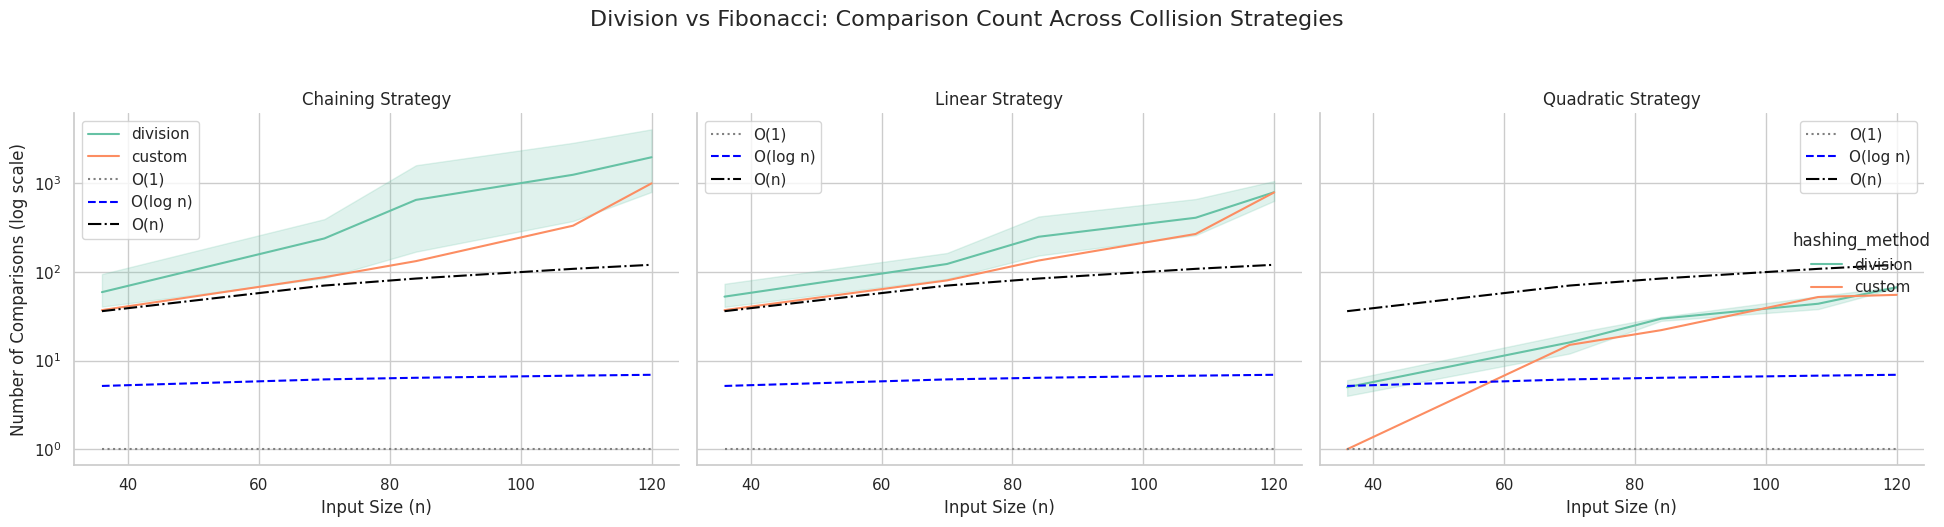

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math

canonical_df = pd.read_csv("summary/canonical_metrics_cleaned.csv")

# Use corrected column names
canonical_df['scheme_type'] = canonical_df['hashing_method'] + " + " + canonical_df['strategy']
canonical_df['input_size'] = canonical_df['input_size'].astype(int)

# Define asymptotic reference curves
n_vals = sorted(canonical_df['input_size'].unique())
asymptotic_O_1 = [1] * len(n_vals)
asymptotic_O_log_n = [math.log2(n) for n in n_vals]
asymptotic_O_n = n_vals

# Set seaborn style and initialize FacetGrid
sns.set(style="whitegrid")
g = sns.relplot(
    data=canonical_df,
    x="input_size",
    y="comparisons",
    hue="hashing_method",
    col="strategy",
    kind="line",
    height=5,
    aspect=1.2,
    palette="Set2"
)

# Add all asymptotic reference curves to each subplot
for ax, (name, subdata) in zip(g.axes.flat, canonical_df.groupby("strategy")):
    ax.plot(n_vals, asymptotic_O_1, linestyle=":", color="gray", label="O(1)")
    ax.plot(n_vals, asymptotic_O_log_n, linestyle="--", color="blue", label="O(log n)")
    ax.plot(n_vals, asymptotic_O_n, linestyle="-.", color="black", label="O(n)")

    ax.set_yscale('log')  # log transform y-axis to improve chaining visibility
    
    ax.set_title(f"{name.title()} Strategy")
    ax.legend()

g.set_axis_labels("Input Size (n)", "Number of Comparisons (log scale)")
g.fig.suptitle("Division vs Fibonacci: Comparison Count Across Collision Strategies", fontsize=16, y=1.05)
plt.tight_layout()
plt.show()


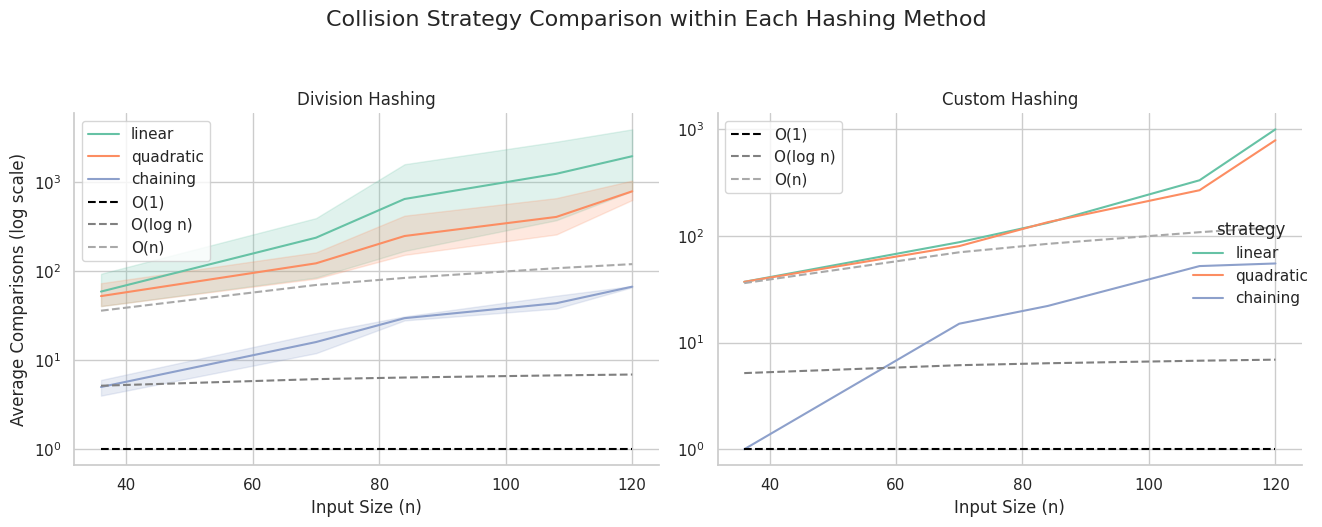

In [14]:



# Correct column mappings
canonical_df['strategy'] = canonical_df['strategy'].str.lower()
canonical_df['hashing_method'] = canonical_df['hashing_method'].str.capitalize()
canonical_df['input_size'] = canonical_df['input_size'].astype(int)
canonical_df['scheme_type'] = canonical_df['hashing_method'] + " + " + canonical_df['strategy']

# Set style
sns.set(style="whitegrid")

# Begin plotting: one column per hashing method, hue by collision strategy
g = sns.relplot(
    data=canonical_df,
    x="input_size",
    y="comparisons",
    hue="strategy",
    col="hashing_method",
    kind="line",
    palette="Set2",
    height=5,
    aspect=1.2,
    facet_kws={'sharey': False}
)

# Add theoretical curves to each subplot
for ax, (name, subdata) in zip(g.axes.flat, canonical_df.groupby("hashing_method")):
    n_vals = sorted(subdata['input_size'].unique())
    ax.plot(n_vals, [1]*len(n_vals), '--', color='black', label='O(1)')
    ax.plot(n_vals, [math.log2(n) for n in n_vals], '--', color='gray', label='O(log n)')
    ax.plot(n_vals, n_vals, '--', color='darkgray', label='O(n)')
    ax.set_yscale('log')
    ax.legend()

# Titles and labels
g.set_titles(col_template="{col_name} Hashing")
g.set_axis_labels("Input Size (n)", "Average Comparisons (log scale)")
g.fig.suptitle("Collision Strategy Comparison within Each Hashing Method", fontsize=16, y=1.05)

plt.tight_layout()
plt.show()


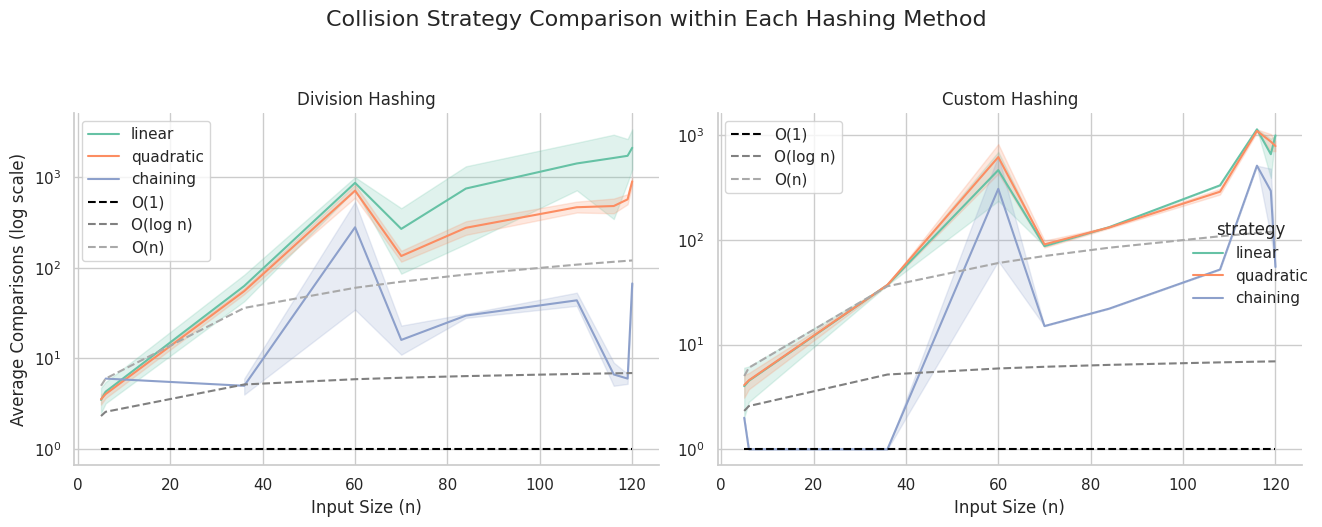

In [13]:
summary_df = pd.read_csv("summary/metrics_summary_cleaned.csv")


# Correct column mappings
summary_df['strategy'] = summary_df['strategy'].str.lower()
summary_df['hashing_method'] = summary_df['hashing_method'].str.capitalize()
summary_df['input_size'] = summary_df['input_size'].astype(int)
summary_df['scheme_type'] = summary_df['hashing_method'] + " + " + summary_df['strategy']

# Set style
sns.set(style="whitegrid")

# Begin plotting: one column per hashing method, hue by collision strategy
g = sns.relplot(
    data=summary_df,
    x="input_size",
    y="comparisons",
    hue="strategy",
    col="hashing_method",
    kind="line",
    palette="Set2",
    height=5,
    aspect=1.2,
    facet_kws={'sharey': False}
)

# Add theoretical curves to each subplot
for ax, (name, subdata) in zip(g.axes.flat, summary_df.groupby("hashing_method")):
    n_vals = sorted(subdata['input_size'].unique())
    ax.plot(n_vals, [1]*len(n_vals), '--', color='black', label='O(1)')
    ax.plot(n_vals, [math.log2(n) for n in n_vals], '--', color='gray', label='O(log n)')
    ax.plot(n_vals, n_vals, '--', color='darkgray', label='O(n)')
    ax.set_yscale('log')
    ax.legend()

# Titles and labels
g.set_titles(col_template="{col_name} Hashing")
g.set_axis_labels("Input Size (n)", "Average Comparisons (log scale)")
g.fig.suptitle("Collision Strategy Comparison within Each Hashing Method", fontsize=16, y=1.05)

plt.tight_layout()
plt.show()


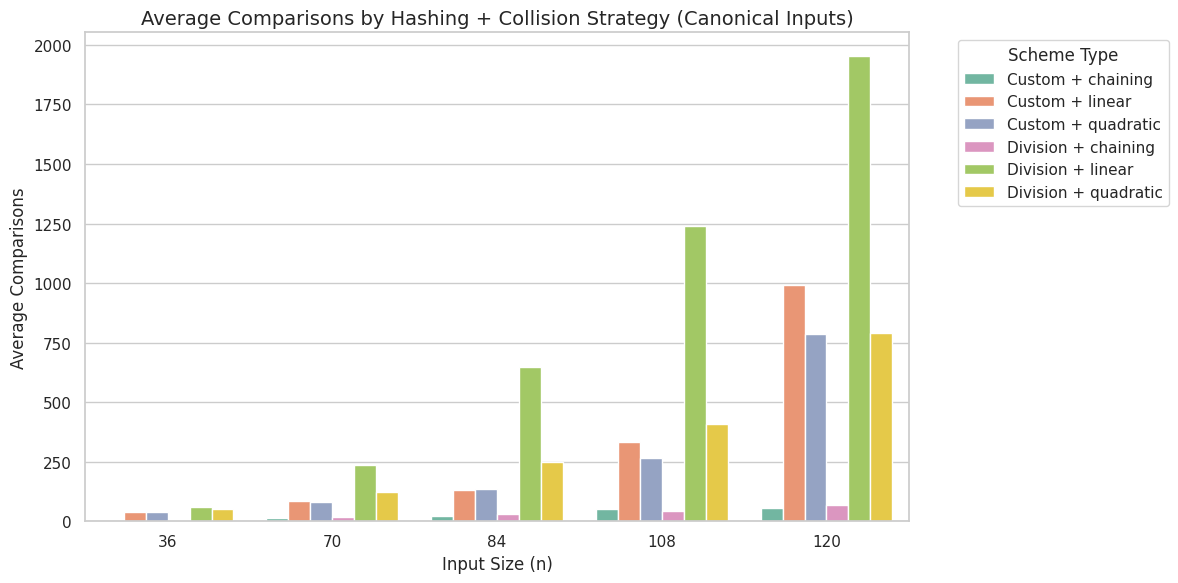

In [15]:
# Correcting column references
canonical_df['scheme_type'] = canonical_df['hashing_method'] + " + " + canonical_df['strategy']

# Aggregate mean comparisons by scheme type and input size
mean_comparisons = (
    canonical_df.groupby(['scheme_type', 'input_size'])['comparisons']
    .mean()
    .reset_index()
)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(
    data=mean_comparisons,
    x="input_size",
    y="comparisons",
    hue="scheme_type",
    palette="Set2"
)

plt.title("Average Comparisons by Hashing + Collision Strategy (Canonical Inputs)", fontsize=14)
plt.xlabel("Input Size (n)")
plt.ylabel("Average Comparisons")
plt.legend(title="Scheme Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


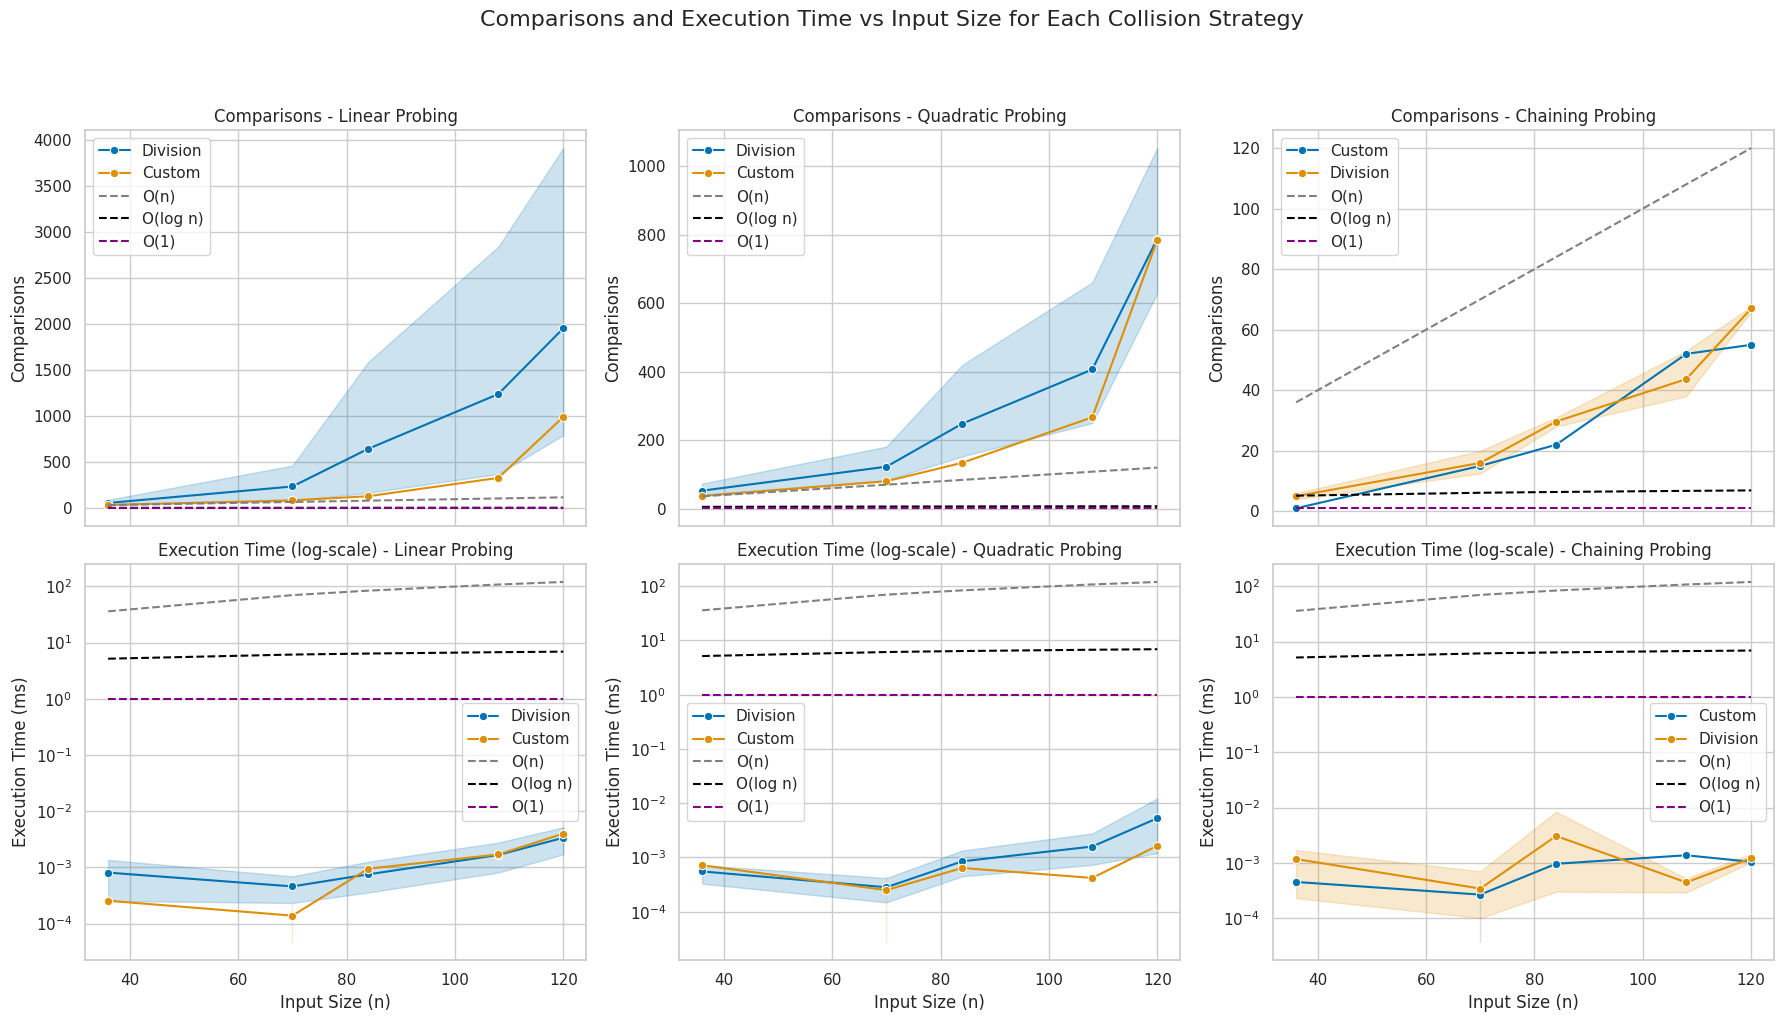

In [21]:
# Determine the number of unique hashing methods
unique_hashing = canonical_df['hashing_method'].unique()
dynamic_palette = sns.color_palette("colorblind", n_colors=len(unique_hashing))




# Unique collision strategies
collisions = ['linear', 'quadratic', 'chaining']
colors = sns.color_palette("colorblind")

# Set style
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True)

# Plot comparisons (row 0) and execution time with log scale (row 1)
for idx, collision in enumerate(collisions):
    subset = canonical_df[canonical_df['strategy'] == collision]

    # Row 0: Number of Comparisons
    ax = axes[0, idx]
    sns.lineplot(data=subset, x='input_size', y='comparisons',
                 hue='hashing_method', marker='o', ax=ax, palette=dynamic_palette)
    n_vals = sorted(subset['input_size'].unique())
    ax.plot(n_vals, n_vals, '--', color='gray', label='O(n)')
    ax.plot(n_vals, [math.log2(n) for n in n_vals], '--', color='black', label='O(log n)')
    ax.plot(n_vals, [1 for _ in n_vals], '--', color='purple', label='O(1)')
    ax.set_title(f"Comparisons - {collision.capitalize()} Probing")
    ax.set_ylabel("Comparisons")
    ax.set_xlabel("Input Size (n)")
    ax.legend()

    # Row 1: Execution Time
    ax = axes[1, idx]
    sns.lineplot(data=subset, x='input_size', y='execution_time',
                 hue='hashing_method', marker='o', ax=ax, palette=dynamic_palette)
    ax.set_yscale('log')
    ax.plot(n_vals, n_vals, '--', color='gray', label='O(n)')
    ax.plot(n_vals, [math.log2(n) for n in n_vals], '--', color='black', label='O(log n)')
    ax.plot(n_vals, [1 for _ in n_vals], '--', color='purple', label='O(1)')
    ax.set_title(f"Execution Time (log-scale) - {collision.capitalize()} Probing")
    ax.set_ylabel("Execution Time (ms)")
    ax.set_xlabel("Input Size (n)")
    ax.legend()

plt.tight_layout()
plt.suptitle("Comparisons and Execution Time vs Input Size for Each Collision Strategy", fontsize=16, y=1.02)
plt.subplots_adjust(top=0.90)
plt.show()


/tmp/ipykernel_138675/3455321841.py:28: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/tmp/ipykernel_138675/3455321841.py:28: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/tmp/ipykernel_138675/3455321841.py:28: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/tmp/ipykernel_138675/3455321841.py:28: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/tmp/ipykernel_138675/3455321841.py:28: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(
/tmp/ipykernel_138675/3455321841.py:28: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.lineplot(


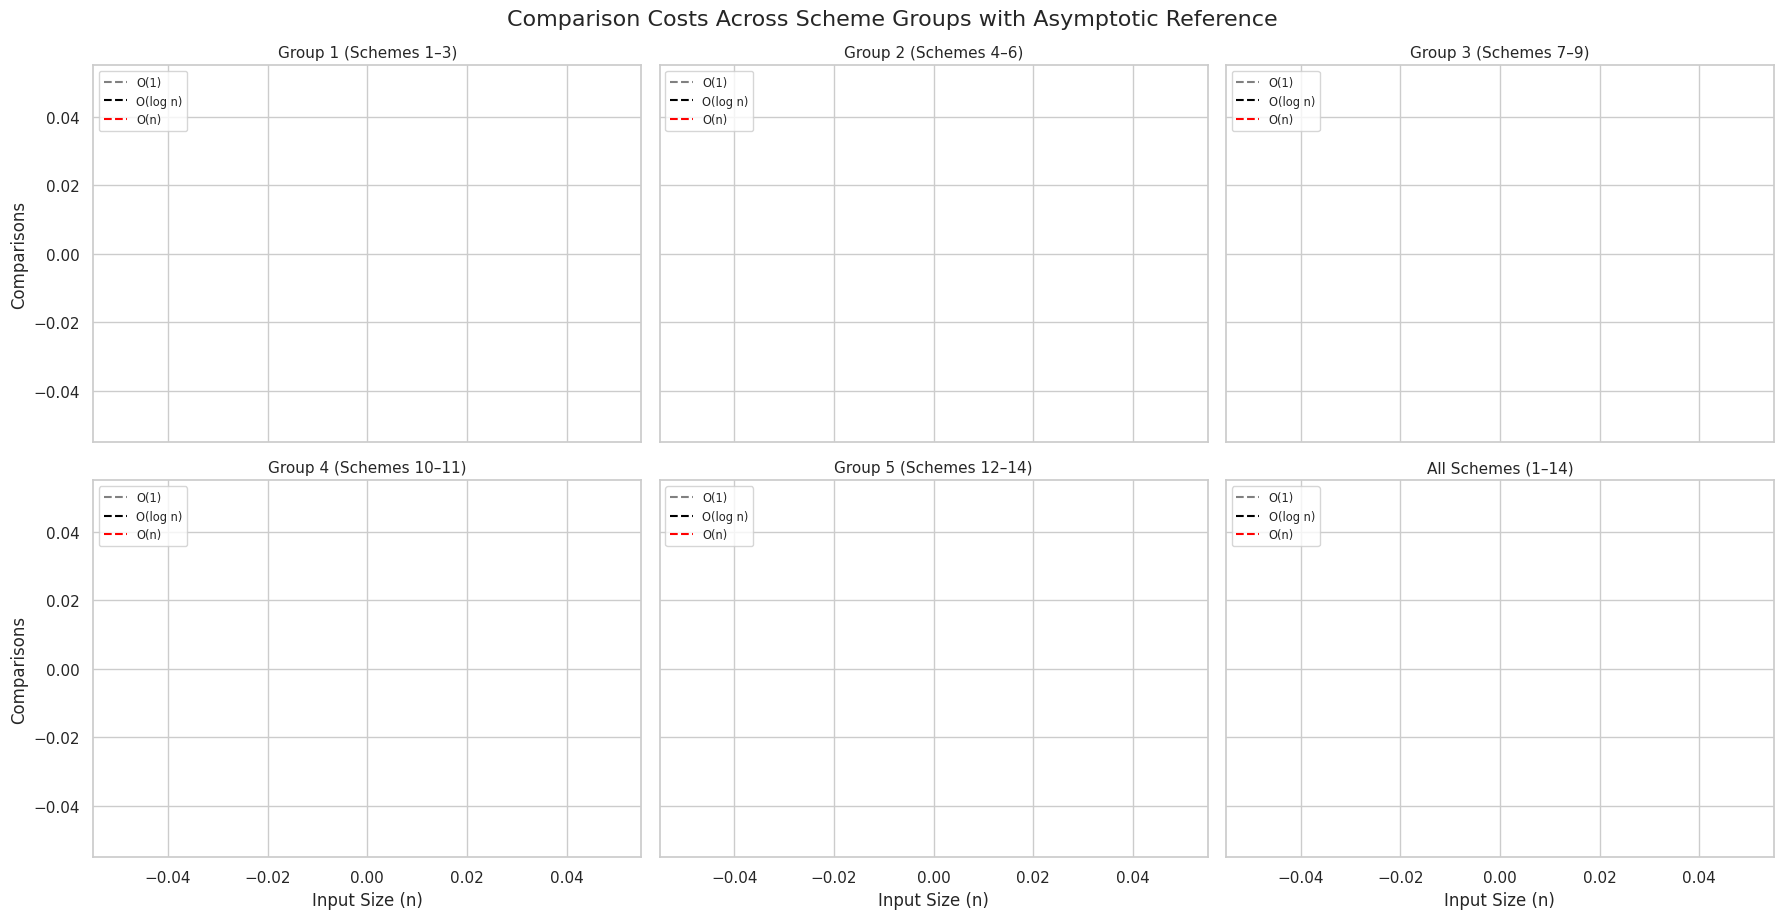

In [24]:
# Convert and compute asymptotic costs
canonical_df['input_size'] = canonical_df['input_size'].astype(int)
canonical_df['O(1)'] = 1
canonical_df['O(log n)'] = np.log2(canonical_df['input_size'])
canonical_df['O(n)'] = canonical_df['input_size']

# Scheme groupings per lab
scheme_groups = {
    "Group 1 (Schemes 1–3)": [1, 2, 3],
    "Group 2 (Schemes 4–6)": [4, 5, 6],
    "Group 3 (Schemes 7–9)": [7, 8, 9],
    "Group 4 (Schemes 10–11)": [10, 11],
    "Group 5 (Schemes 12–14)": [12, 13, 14],
    "All Schemes (1–14)": list(range(1, 15))
}

# Initialize plot
sns.set(style="whitegrid")
fig, axes = plt.subplots(2, 3, figsize=(18, 9), sharex=True, sharey=True)
axes = axes.flatten()

# Plot each group
for idx, (group_name, scheme_ids) in enumerate(scheme_groups.items()):
    ax = axes[idx]
    group_df = canonical_df[canonical_df['scheme'].isin(scheme_ids)].copy()
    group_df['Scheme Label'] = group_df['scheme'].apply(lambda x: f"Scheme {x}")

    sns.lineplot(
        data=group_df,
        x="input_size",
        y="comparisons",
        hue="Scheme Label",
        marker="o",
        ax=ax,
        palette="tab10"
    )

    # Add asymptotic references
    x_vals = sorted(group_df['input_size'].unique())
    ax.plot(x_vals, [1 for _ in x_vals], '--', color='gray', label="O(1)")
    ax.plot(x_vals, [math.log2(x) for x in x_vals], '--', color='black', label="O(log n)")
    ax.plot(x_vals, x_vals, '--', color='red', label="O(n)")

    ax.set_title(group_name, fontsize=11)
    ax.set_xlabel("Input Size (n)")
    ax.set_ylabel("Comparisons")
    ax.legend(fontsize="x-small", loc="upper left")

plt.tight_layout()
plt.suptitle("Comparison Costs Across Scheme Groups with Asymptotic Reference", fontsize=16, y=1.02)
plt.show()
